<a href="https://colab.research.google.com/github/OnkarSuryavanshi/GRIPIOT/blob/main/TRAFFIC_SIGN_RECOGNITION_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Computer Vision & IOT 

# TASK 1 : TRAFFIC SIGN CLASSIFICATION SYSTEM 

**Onkar Suryavanshi**


MAY 2023 BATCH 


Implement a realtime traffic sign classifier which classifies the traffic sign and gives alert.

IMPORTING LIBRARIES 

In [40]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Recognising Traffic Signs

In [9]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2023-05-23 12:30:03--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  15.2MB/s    in 18s     

2023-05-23 12:30:22 (14.6 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [10]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

43

In [11]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

# EXAMPLES OF EACH TRAFFIC SIGN 

<ipython-input-11-d18a9dfb7726>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  images = torch.as_tensor(images)


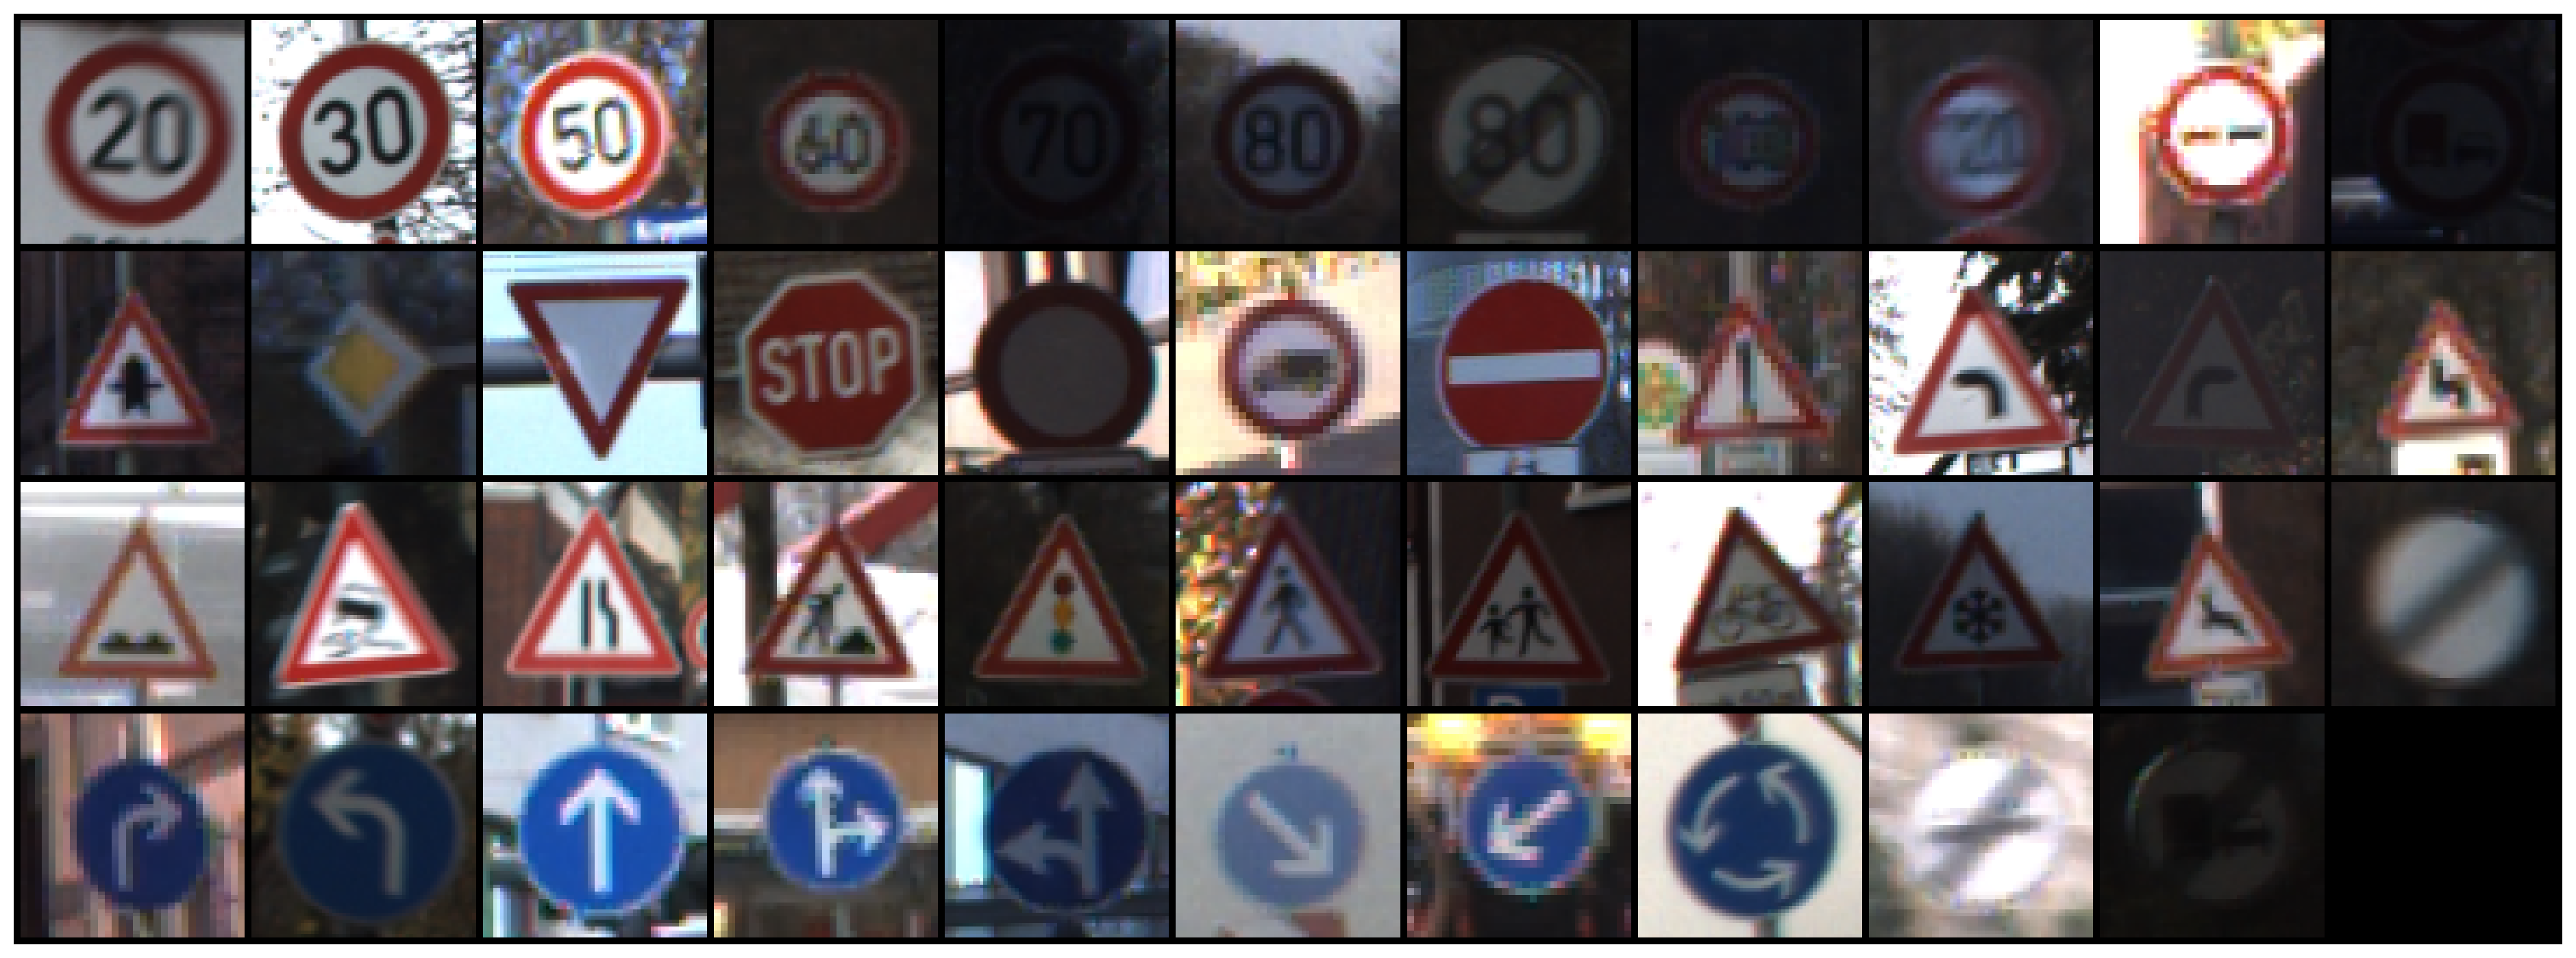

In [12]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

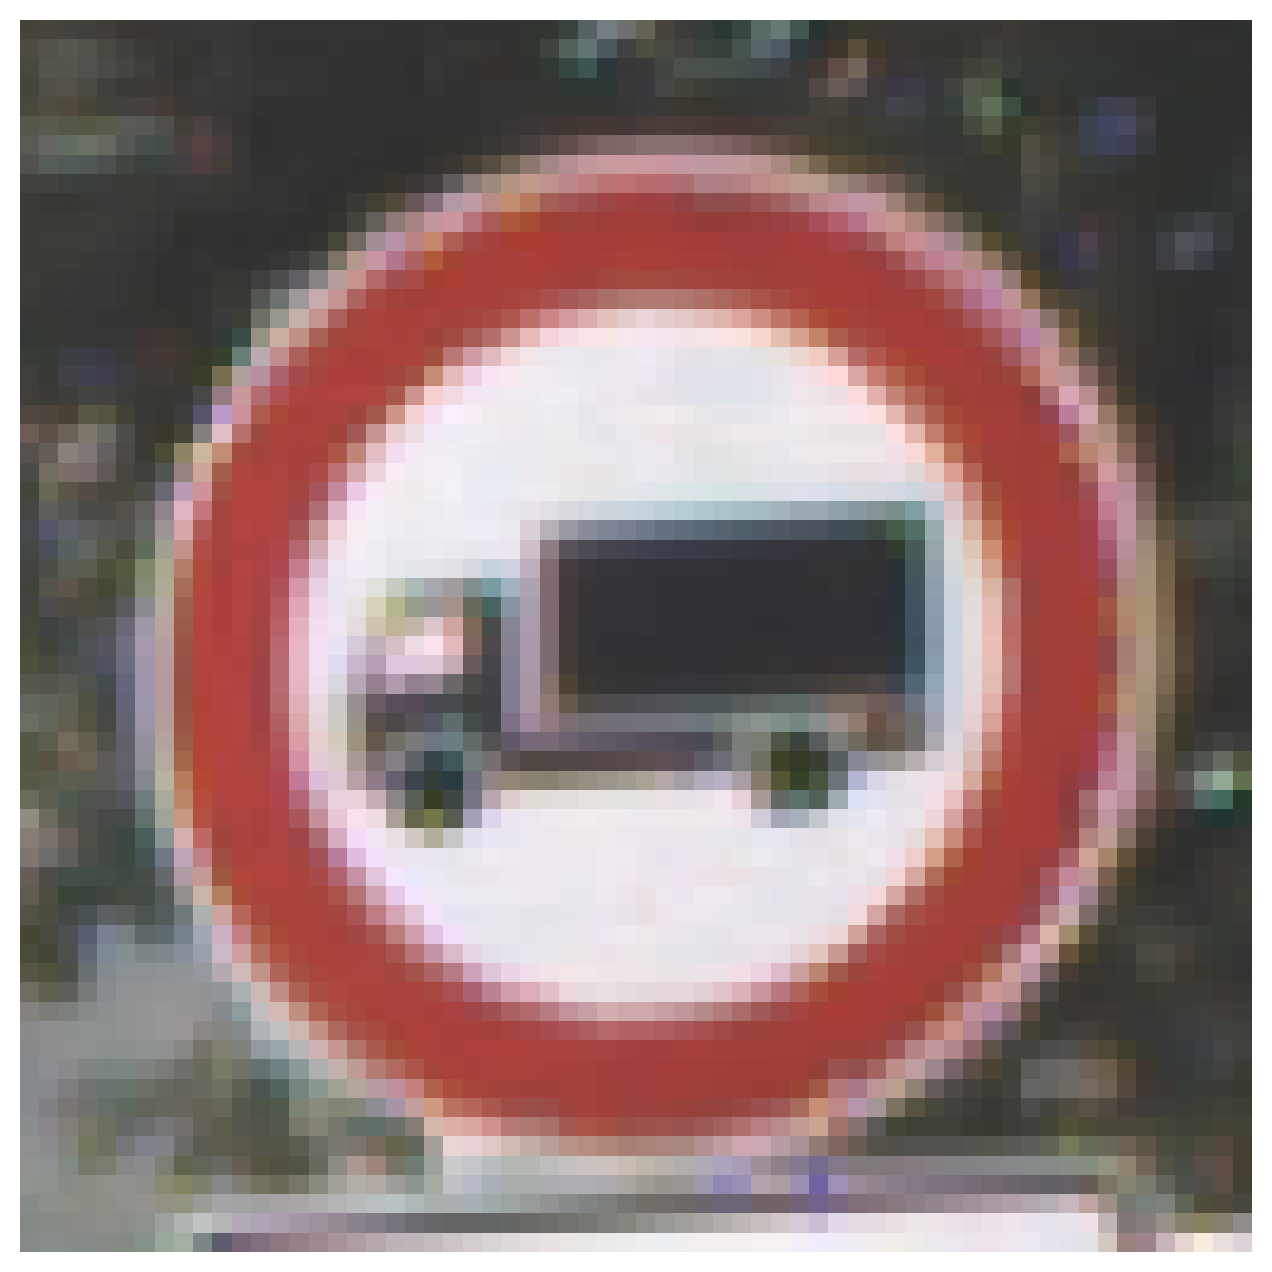

In [15]:
img_path = glob(f'{train_folders[16]}/*ppm')[1]

show_image(img_path)

# BUILDING A DATASET     
4 classes are selected out of 42 for recognising the traffic sign .

In [16]:
class_names = ['priority_road', 'give_way', 'stop', 'no_entry']

class_indices = [12, 13, 14, 17]

In [17]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [18]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

priority_road: 2100
give_way: 2160
stop: 780
no_entry: 1110


In [19]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [20]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [21]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 4920, 'val': 615, 'test': 615}

In [42]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True)

  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

In [24]:
base_model = create_model(len(class_names))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 305MB/s]


# BUILDING THE MODEL

In [25]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [27]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=3):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

# TRAINING THE MODEL

In [28]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/3
----------
Train loss 0.320436649710982 accuracy 0.8890243902439025
Val   loss 0.005608595815185443 accuracy 0.9983739837398374

Epoch 2/3
----------
Train loss 0.11515726483001906 accuracy 0.9623983739837398
Val   loss 0.002799798949571265 accuracy 1.0

Epoch 3/3
----------
Train loss 0.07813127367781278 accuracy 0.9752032520325203
Val   loss 0.01409001677088381 accuracy 0.9934959349593496

Best val accuracy: 1.0
CPU times: user 2min 5s, sys: 5.61 s, total: 2min 11s
Wall time: 2min 34s


In [38]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title( class_names[preds[j]])
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

# EVALUATION 

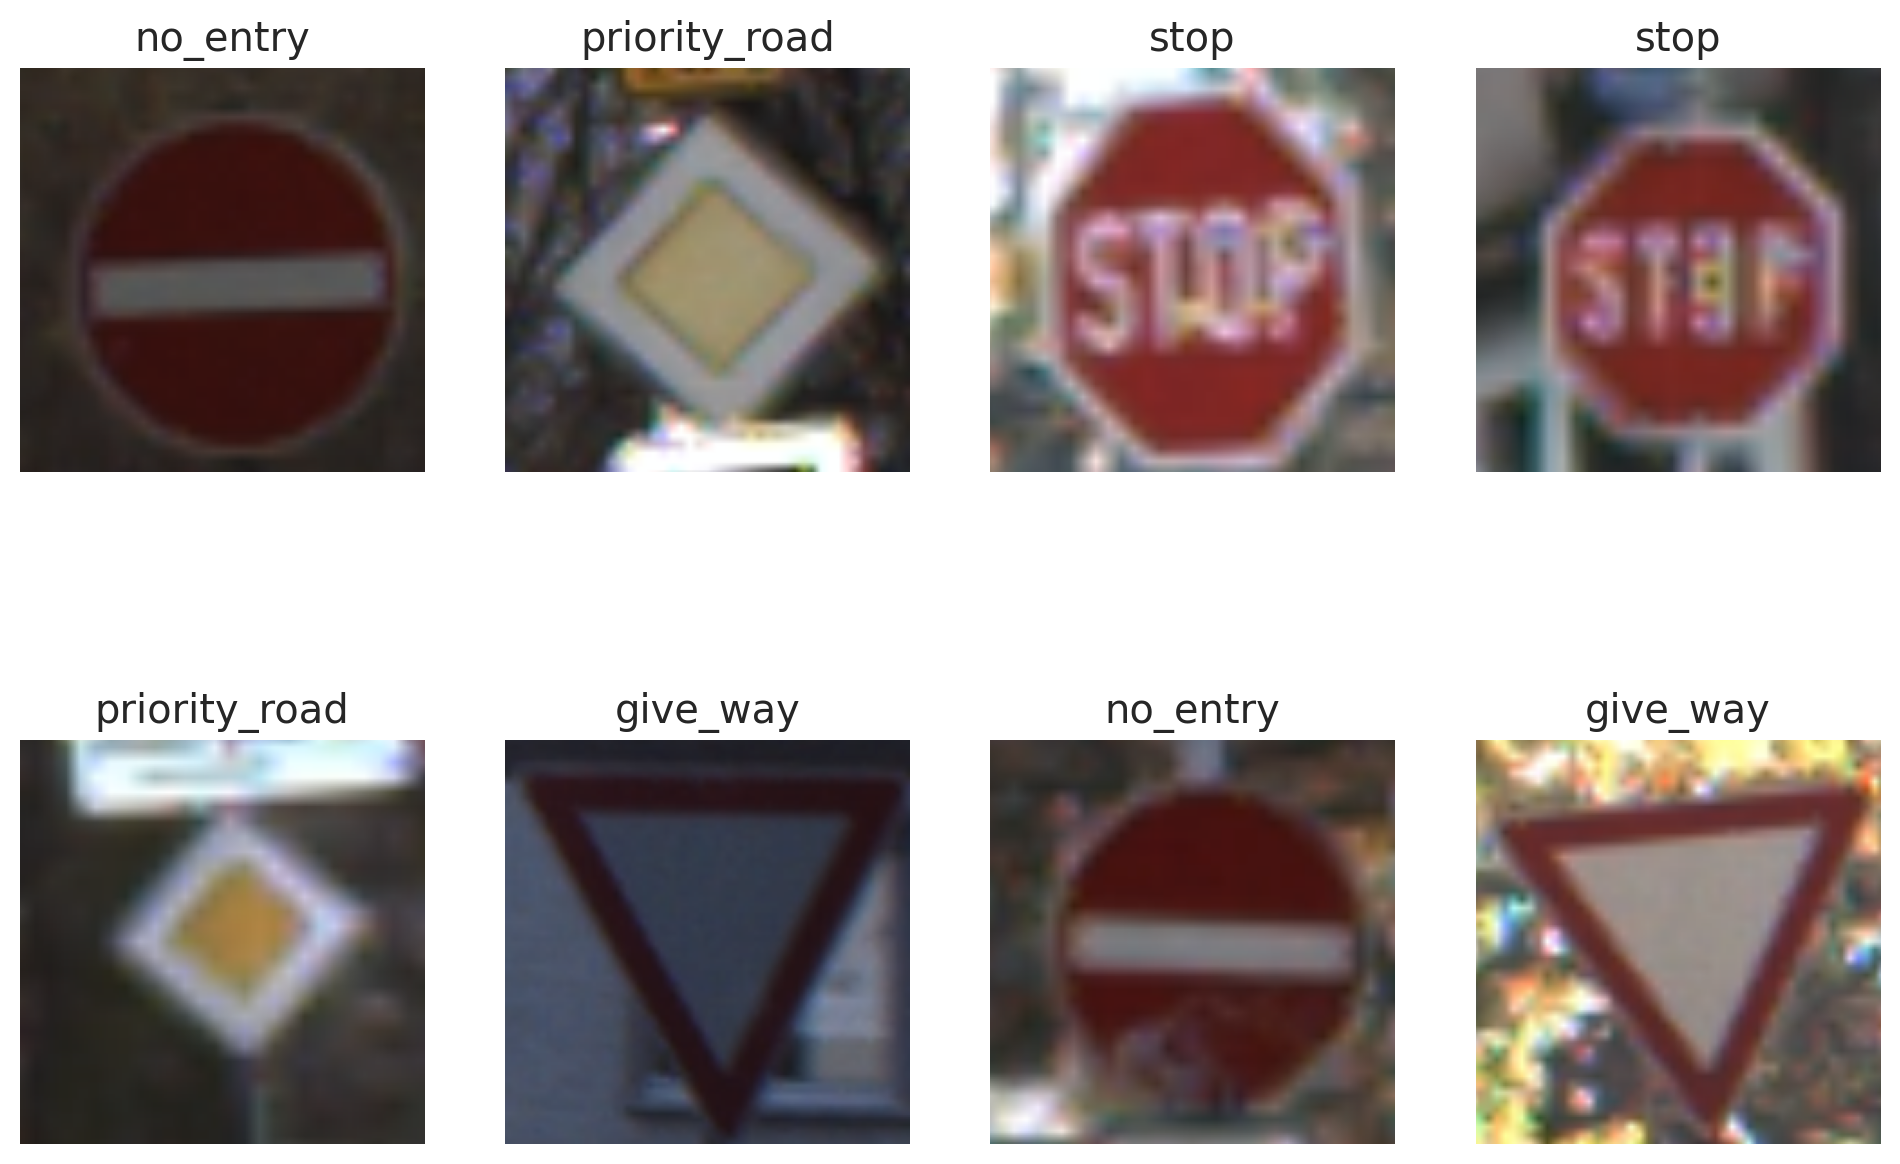

In [39]:
show_predictions(base_model, class_names, n_images=8)